# Englacial borehole temperature modelling experiments

#### 

***

#### 


## 1. Introduction
This notebook demonstrates how to run and plot results from a python version of the simple one-dimensional englacial temperature model presented in: 

Montelli, A. and Kingslake, J.: Geothermal heat flux is the dominant source of uncertainty in englacial-temperature-based dating of ice-rise formation, 2022, EGUsphere [preprint], https://doi.org/10.5194/egusphere-2022-236.

Ultimately, the primary purpose of the paper is to examine what information (and with what uncertainties) about climate and glacial history can be inferred from englacial temperatures measured within ice rises - regions of slow-flowing, locally elevated, grounded ice embedded within or adjacent to fast-flowing, floating ice shelves. Due to their proximity to the marine ice-sheet periphery and negligible horizontal flow, ice rises can retain an imprint of past grounding line migration on millennial timescales, a record that is otherwise largely inaccessible beneath the ice sheet or its fringing ice shelves.

Digitized borehole measurements and input datasets that were used to produce some of the results can be found [here](https://github.com/sashamontelli/borehole_temperature_models).

This notebook summarizes the model and the implementation of the python code to solve the equations. It also demonstrates sensitivity experiments and inversion of borehole measurements presented in the paper.

### 1.1. Importing the required modules

Several modules will be needed to implement the presented version of the code.

In [1]:
import sys
import warnings

from pathlib import Path 

import geopandas as gpd
import matplotlib as mpl
import numpy as np
import pyproj
import scipy
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
from tqdm import tqdm

from icetemp.ModelMeasured import ModelMeasured
from icetemp.InversionMCMCSimulation import Simulate, DEFAULT_NUM_WALKERS, DEFAULT_NUM_ITERATIONS, DEFAULT_NUM_BURNIN_ITERATIONS
from icetemp.TemperatureModel import TemperatureModel
from icetemp import Utilities

from Notebook import Cell

***

#### 


## 2. The model
Refer to the paper cited above for the full details of the model equations. Here we will summarize it so users get some familiarity with the physics and the variables being solved for. 

### 2.1. Equations

The model solves the vertical diffusion-advection equation to simulate the time- and depth-evolution of temperature through one-dimensional column of slow-flowing ice (i.e., ice where horizontal flow component is negligibly small). It is described by the following partial differential equation:

\begin{equation}
  \label{eq:Adv_dif}
  \frac{\partial T}{\partial t}  =  \alpha \left( \frac{\partial}{\partial z} \right)  \frac{\partial T}{\partial z} - w \frac{\partial T}{\partial z}  \;, \tag{1}
\end{equation}

where ${t}$ is time, ${z}$ is height above the bed, ${w}$ is vertical ice velocity (positive upwards) and ${\alpha}$ is thermal diffusivity: 

\begin{equation}
  \label{eq:Alpha}
  \alpha = \frac{k} {\rho c} 
  \;, \tag{2}
\end{equation}


Where ${\rho}$ is density, ${k}$ is the thermal conductivity, ${c}$ is the specific heat capacity, and ${w}$ is vertical velocity within the ice column. For sensitivity experiments, we implement three analytical approximations for vertical velocity within grounded ice. The Dansgaard and Johnsen (1969) vertical flow approximation can be formulated as:

\begin{equation}
  \label{eq:vwDJ1}
  w(z,z_k) = -w_s(t) \frac{2z - z_k} {2H - z_k}    
  \;, \tag{3}
\end{equation}


for   \begin{equation}
  \label{eq:vwDJ1c}
  z_k \leqslant z \leqslant H  
  \;, 
\end{equation}

and

\begin{equation}
  \label{eq:vwDJ2}
  w(z,z_k) = -w_s(t) \frac{z^2} {(2H - z_k)z_k }
  \;, \tag{4}
\end{equation}


for   \begin{equation}
  \label{eq:vwDJ2c}
  0 \leqslant z \leqslant z_k  
  \;, 
\end{equation}

Another commonly used vertical flow approximation by Lliboutry (1979) can be formulated as:


for   \begin{equation}
  \label{eq:vwLl}
  w(z,t) = w_s(t) \left[ 1 - \frac{n + 2}{n + 1}\left(1 - \frac{z}{H(t)}\right) + \frac{1}{n + 1}\left(1 - \frac{z}{H(t)}\right)^{n+2} \right]
  \;, \tag{5}
\end{equation}

where ${n}$ is a rheological parameter (Glen's flow law exponent).

Finally, a simplified approximation where vertical velocity varies linearly with depth from zero at the base to a maximum value at the surface, following Bindschadler et al (1990), was implemented for sensitivity experiments and estimation of associated uncertainties:
  
\begin{equation}
  \label{eq:vwBind}
  w(z,t) = w_s(t)  \frac {z}{H(t)} 
  \;, \tag{6}
\end{equation}

When time-varying ice thickness is introduced, the difference between accumulation and thickening rates determines the vertical velocity at the surface:

\begin{equation}
  \label{eq:vwBind1}
  w_s(t) = a(t) -  \frac {\partial H(t)}{\partial t} 
  \;, \tag{7}
\end{equation}

For temperature calculations within the underlying bedrock, no vertical advection is assumed (${w}=0$), reducing Eq. 1 to only account for heat diffusion.

### 2.2. Numerics and boundary conditions

A one-dimensional spatial domain is defined, extending vertically from the bedrock base to the ice surface. The vertical coordinate is ${z}$, which increases upwards. A simple finite-difference scheme is implemented to solve Eq. 1. The spatial domain is discretisized with a minimum of 50 nodes within the ice column and 50 nodes with fixed 10 m vertical spacing in the subjacent bedrock. Time step is set to equal 1 year. In a scenario where ice thickness varies through time, vertical grid spacing in the ice column is adapted and temperature values are interpolated accordingly at each time step. The model can be run under two different assumptions about whether the ice column is a part of a grounded ice rise or a floating ice shelf.

In the ice-shelf scenario boundary conditions at the ice surface are set by time-variable surface temperatures ${T(t)}$ and accumulation rates ${a(t)}$. The temperature at the top of bedrock/base of ice column ${T(z=z_b)}$ is forced to equal the freezing point of seawater (calculated as a function of ice thickness, to account for its pressure dependence), and the temperature gradient in the bedrock is calculated based on the geothermal heat flux ${G}$. The rates of accumulation and basal melting are assumed to balance each other out.

When modelling temperatures within a grounded ice sheet (i.e., an ice rise), the boundary condition at the base of the ice column is set such that the vertical gradient in ${T}$ corresponds to a diffusive heat flux that balances the geothermal heat flux ${G}$ through the underlying bedrock. Thickness history ${H(t)}$ and the vertical velocity function (Eqs. 3-6) within the ice rise are also used. The boundary conditions at the top of the ice column are prescribed based on the temperature and accumulation rate histories.

#### 


***
## 3. Forward model code demonstration

Here, plotting parameters are set for the figures and fonts used therein.

In [2]:
mpl.rcParams['figure.figsize'] = 12, 7
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

plt.rcParams.update({
    'font.sans-serif': 'Arial', # need to run conda install -c conda-forge -y mscorefonts for Arial
    'font.family': 'Arial',
    'font.size': 11,
    'figure.titlesize': 12,
    'figure.titleweight': 'bold',
    'lines.linewidth' : 0.5,
    'lines.markersize' : 2,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
    'grid.linewidth': 0.1,
    'axes.titlesize': 11,
    'axes.titleweight' : 'bold',
    'axes.labelsize': 11,
    'axes.labelweight': 'bold',
    'axes.linewidth': 0.5,
    'pdf.fonttype': 42
})

### 3.1. Loading the required parameters for temperature calculation

Several constants and parameter values are required prior to running the code.

A full list of the predefined constants is in the table below.

| Constant | Default value | Description |
| --- | --- | --- |
| `c_i`|`2000`|Heat capacity of ice (${J}$ $kg^{-1}$ $K^{-1}$) |
| `c_r`|`790`|Heat capacity of bedrock (${J}$ $kg^{-1}$ $K^{-1}$) |
| `k_i`|`2.3`|Thermal conductivity of ice at ~260ºK (${W}$ $m^{-1}$ $K^{-1}$) |
| `k_r`|`2.8`|Thermal conductivity of bedrock (${mW}$ $m^{-2}$) |
| `rho_i`|`918`|Density of ice (${kg}$ $m^{3}$) |
| `rho_r`|`2750`|Density of bedrock (${kg}$ $m^{3}$) |
| `n`|`3`|Glen's flow law exponent |
| `g`|`9.18`| Gravitational acceleration (${m}$ $s^{-2}$) |
| `A`|`2e-16`|Rheological constant determining soft ice as a function of temperature |

Note that thermal conductivity is assumed constant here; in reality, however, conductivity of ice is temperature-dependant (e.g., ranging from from 2 ${W}$ $m^{-1}$ $K^{-1}$ (for ice close to the pressure melting point) to 2.6 ${W}$ $m^{-1}$ $K^{-1}$ for ice at -30ºC. Temperature-dependent conductivity effects can be explored in sensitivity experiments similar to those presented further in this notebook.

In [ ]:
# Execute this cell to display the contents for `src/icetemp/Constants.py`

with open("src/icetemp/Constants.py") as f:
    code = f.read()
    
display(HTML(highlight(code, PythonLexer(), HtmlFormatter())))


### 3.2. Defining the model

The model is written as a function of several variables for convenient execution of numerous sensitivity tests that will follow. In this case, model takes the following variables as an input:

| Parameter |Description |
| --- | --- |
|`H_i`|Ice thickness history ${H(t)}$ |
|`H_r`|Time-constant thickness of subglacial bedrock |
|`dz`|Spatial grid resolution in metres " |
|`t_steady_years_total`|Time (in years) required to reach steady state temperature profile |
|`t_forcing_years`|Time period ${t}$ (in years) when forcings are time-variable |
|`t_ungrounding`|Time (years before present) when ice becomes ungrounded |
|`t_grounding`|Time (years before present) when ice becomes grounded |
|`T_sim`|Temperature history ${T(t)}$ |
|`a_sim`|Accumulation history ${a(t)}$ |
|`G`|Geothermal heat flux |


In [ ]:
# Execute this cell to display the contents for `src/icetemp/TemperatureModel.py`

with open("src/icetemp/TemperatureModel.py") as f:
    code = f.read()
    
display(HTML(highlight(code, PythonLexer(), HtmlFormatter())))

### 3.3. Demo run of the function

To facilitate quantitative comparison between different temperature profiles, two functions are introduced. First function (**RMS**) calculates root-mean squared between two vectors of the same length following the following equation:


\begin{equation}
  \label{eq:RMS}
  RMS = \sqrt{\frac {\sum_{i=1}^n (T_m - T_p)^2} {n}}
  \;, \tag{8}
\end{equation}


where ${T_m}$ and ${T_p}$ are the measured and predicted temperatures at each grid point ${i}$, and ${n}$ is the number of grid points. The other function (**rsmpl**) resamples temperature profile into a regular grid with fixed spacing. 

#### Implementing the function and plotting the results

Here is an example of running the function and plotting the output. Here we try two different sets of variables and plot the resultant temperature profiles next to the borehole measurements reported from Crary Ice Rise by Bindschadler et al (1991).

0:00:3.68


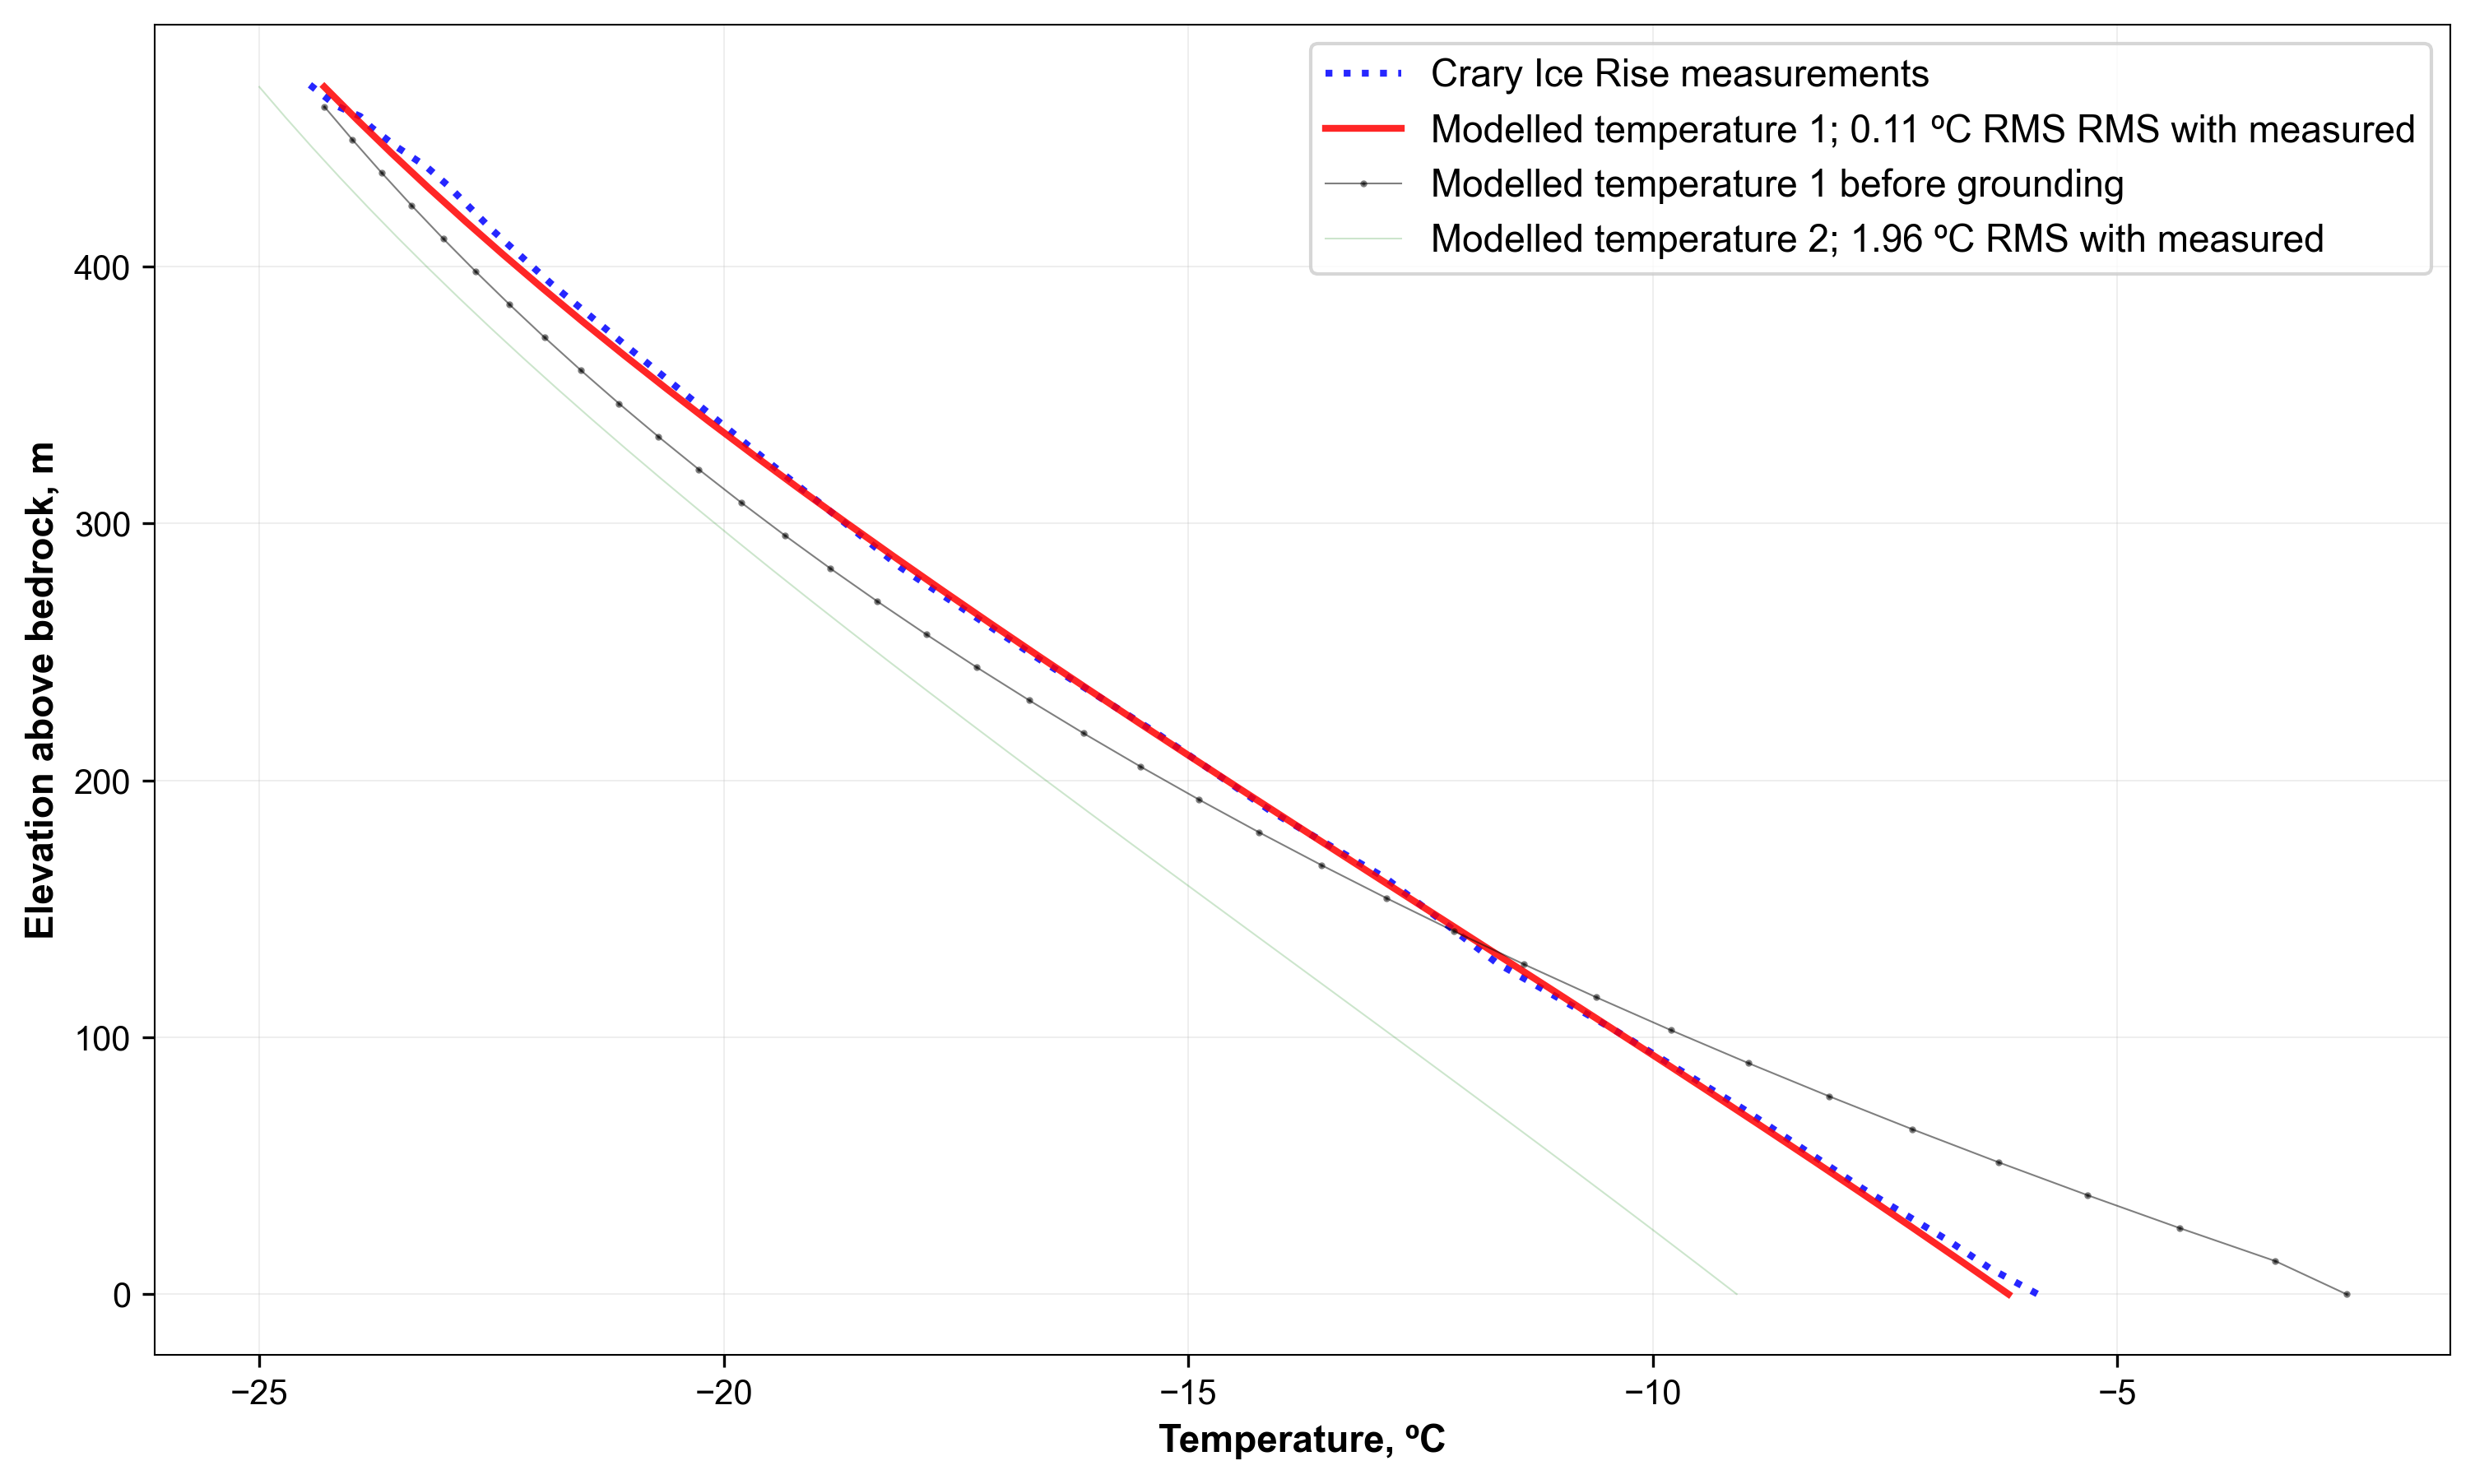

In [3]:
with Cell():
    ##### Implementing the forward model with some set of prior parameters
    with Utilities.Timer():
        Tm_1 = TemperatureModel.Create(1, [360,470], 500, 10, 5e4, 1e4, 1e4, 7e2, [-24.3, -24.3], [0.11, 0.11], 950e-4)
        Tm_2 = TemperatureModel.Create(1, [400,470], 500, 10, 5e4, 1e4, 1e4, 2e3, [-30, -25], [0.2, 0.1], 700e-4)

        ##### Importing previously measured temperatures from Bindschadler et al 1991

        Bindschadler_Crary_T_profile = np.genfromtxt('Crary Ice RIse borehole measurements from Bindschadler et al 1991/Binschadler_Crary_D_Borehole_Temperatures.csv', delimiter=',', skip_header=1)

        ### Calculating RMS difference between modelled and calculated profiles

        T_interp_Bind = Utilities.rsmpl(Bindschadler_Crary_T_profile[:,0], Bindschadler_Crary_T_profile[:,1], 10)

        T_interp_modelled_1 = Utilities.rsmpl(Tm_1.Tvar_H_Tmatrix[:,-1], Tm_1.zvar_H_Tmatrix[:,-1], 10)
        T_interp_modelled_2 = Utilities.rsmpl(Tm_2.Tvar_H_Tmatrix[:,-1], Tm_2.zvar_H_Tmatrix[:,-1], 10)
        RMS_Crary_1 = Utilities.RMS(T_interp_modelled_1[0], T_interp_Bind[0])
        RMS_Crary_2 = Utilities.RMS(T_interp_modelled_2[0], T_interp_Bind[0])

    ##### Plot the results

    plt.plot(Bindschadler_Crary_T_profile[:,0], Bindschadler_Crary_T_profile[:,1], 'b:', linewidth=2, alpha=0.85,  label='Crary Ice Rise measurements')
    plt.plot(Tm_1.Tvar_H_Tmatrix[50:,-1], Tm_1.zvar_H_Tmatrix[50:,-1], 'r', linewidth=2, alpha=0.85, label="Modelled temperature 1; {:0.2f} ºC RMS RMS with measured".format(RMS_Crary_1))
    plt.plot(Tm_1.Tvar_H_Tmatrix[50:,-700], Tm_1.zvar_H_Tmatrix[50:,-700], 'k.-', linewidth=0.5, alpha=0.5, label="Modelled temperature 1 before grounding")

    plt.plot(Tm_2.Tvar_H_Tmatrix[50:,-1], Tm_2.zvar_H_Tmatrix[50:,-1], 'g', linewidth=0.5, alpha=0.2, label="Modelled temperature 2; {:0.2f} ºC RMS with measured".format(RMS_Crary_2))
    plt.ylabel('Elevation above bedrock, m')
    plt.xlabel('Temperature, ºC')
    plt.grid()
    plt.legend()


##### Restart the code to update the figure quality according to the following figure parameters:

mpl.rcParams['figure.figsize'] = 12, 7
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

This demo run shows two different temperature profiles produced by the model, one of which (thick red line) has a close match (0.11 ºC root mean squared difference) between modelled and measured (dashed blue line) temperature profiles. Next section will run a series of simulations to explore the general model sensitivity to the parameter values.

#### 


***

#### 

## 4. Forward model sensitivity experiments

In this section, we perform an ensemble of simulations, in which uncertain parameters are perturbed. The resultant temperature profiles are then compared to examine how altering our prior parameters affected the final temperature profiles. Here, we assign thickness, temperature and accumulation to a fixed value. In the paper, we use outputs from large-scale PISM models as an input for our targeted model. Instructions on how to use PISM model outputs can be found [here](https://gallery.pangeo.io/repos/ldeo-glaciology/pangeo-glaciology-examples/04_paleo_PISM.html).

In [4]:
with Cell("model_sensitivity", preserve_as_class=True):
    def InitGlobalModel(
        name: str,
        *,
        Hi_sim: list[int]=[1750, 1750],
        Hr: int=500,
        dz: int=10,
        t_steady_years_total: float=5e4,
        t_forcing_years: float=2e4,
        t_ungrounding: float=0,
        t_grounding: float=0,
        T_sim: list[float]=[-30, -30],
        a_sim: list[float]=[0.2, 0.2],
        G: float=600e-4,
    ):
        sys.stdout.write("{}...".format(name))
        sys.stdout.flush()
    
        with Utilities.Timer():
            model = TemperatureModel.Create(1, Hi_sim, Hr, dz, t_steady_years_total, t_forcing_years, t_ungrounding, t_grounding, T_sim, a_sim, G)
        
        # Dynamically add this variable to the global variables
        globals()[name] = model


    # Create models with varying Geothermal heat flux values
    for name, g_value in [
        ("Tmodel_G_low",      400e-4),
        ("Tmodel_G_med_low",  500e-4),
        ("Tmodel_G_mean",     600e-4),
        ("Tmodel_G_med_high", 700e-4),
        ("Tmodel_G_high",     800e-4),
    ]:
        InitGlobalModel(name, G=g_value)
        
    sys.stdout.write("\n")
    
    # Create models with varying temperature history
    for name, temperature_history in [
        ("Tmodel_T_low",      [-35,   -35]),
        ("Tmodel_T_med_low",  [-32.5, -32.5]),
        ("Tmodel_T_mean",     [-30,   -30]),
        ("Tmodel_T_med_high", [-27.5, -27.5]),
        ("Tmodel_T_high",     [-25,   -25]),
    ]:
        InitGlobalModel(name, T_sim=temperature_history)
    
    sys.stdout.write("\n")
    
    # Create models with varying accumulation history
    for name, accumulation_history in [
        ("Tmodel_a_low",      [0.1,  0.1]),
        ("Tmodel_a_med_low",  [0.15, 0.15]),
        ("Tmodel_a_mean",     [0.2,  0.2]),
        ("Tmodel_a_med_high", [0.25, 0.25]),
        ("Tmodel_a_high",     [0.3,  0.3]),
    ]:
        InitGlobalModel(name, a_sim=accumulation_history)
    
    sys.stdout.write("\n")
    
    # Create models with varying grounding times
    for name, grounding_years in [
        ("Tmodel_t_low",      5e2),
        ("Tmodel_t_med_low",  1e3),
        ("Tmodel_t_mean",     2e3),
        ("Tmodel_t_med_high", 4e3),
        ("Tmodel_t_high",     8e3),
    ]:
        InitGlobalModel(
            name, 
            t_steady_years_total=4e4,
            t_forcing_years=1e5,
            t_ungrounding=4e4,
            t_grounding=grounding_years,
        )
    
    sys.stdout.write("\nDONE!\n")

Tmodel_G_low...0:00:6.72
Tmodel_G_med_low...0:00:6.66
Tmodel_G_mean...0:00:6.76
Tmodel_G_med_high...0:00:6.80
Tmodel_G_high...0:00:7.03

Tmodel_T_low...0:00:6.53
Tmodel_T_med_low...0:00:6.87
Tmodel_T_mean...0:00:6.69
Tmodel_T_med_high...0:00:6.94
Tmodel_T_high...0:00:9.04

Tmodel_a_low...0:00:9.03
Tmodel_a_med_low...0:00:8.64
Tmodel_a_mean...0:00:9.78
Tmodel_a_med_high...0:00:7.43
Tmodel_a_high...0:00:8.80

Tmodel_t_low...0:00:41.28
Tmodel_t_med_low...0:00:43.32
Tmodel_t_mean...0:00:34.42
Tmodel_t_med_high...0:00:38.92
Tmodel_t_high...0:00:40.22

DONE!


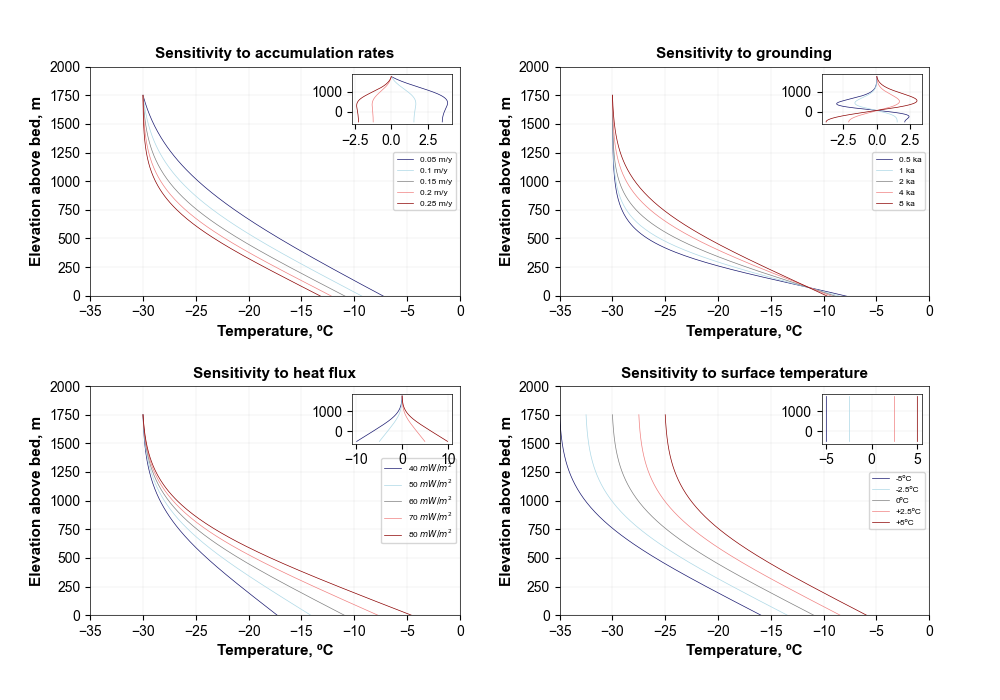

In [5]:
%matplotlib ipympl

# mpl.rcParams['figure.figsize'] = 12, 7
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 300

plt.rcParams.update({
    'font.sans-serif': 'Arial', # need to run conda install -c conda-forge -y mscorefonts for Arial
    'font.family': 'Arial',
    'font.size': 11,
    'figure.titlesize': 12,
    'figure.titleweight': 'bold',
    'lines.linewidth' : 0.5,
    'lines.markersize' : 2,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
    'grid.linewidth': 0.1,
    'axes.titlesize': 11,
    'axes.titleweight' : 'bold',
    'axes.labelsize': 11,
    'axes.labelweight': 'bold',
    'axes.linewidth': 0.5,
    'pdf.fonttype': 42
})

with Cell(dependencies="model_sensitivity"):
    fig, ax = plt.subplots(figsize=(10, 7), ncols=2, nrows = 2)
    fig.tight_layout(pad=4.0)

    z =  model_sensitivity.Tmodel_G_mean.zvar_H_Tmatrix[:,-1]

    # ----------------------------------------------------------------------
    def PlotLine(
        subplot,
        matrix,
        color,
        label,
    ):
        subplot.plot(
            matrix,
            z,
            color,
            label=label,
            linewidth=0.5,
        )

    # ----------------------------------------------------------------------

    for (
        x, y,
        desc,
        low_model,
        low_units,
        med_low_model,
        med_low_units,
        mean_model,
        mean_units,
        med_high_model,
        med_high_units,
        high_model,
        high_units,
    ) in [
        (
            0, 0,
            "accumulation rates",
            model_sensitivity.Tmodel_a_low,
            "0.05 m/y",
            model_sensitivity.Tmodel_a_med_low,
            "0.1 m/y",
            model_sensitivity.Tmodel_a_mean,
            "0.15 m/y",
            model_sensitivity.Tmodel_a_med_high,
            "0.2 m/y",
            model_sensitivity.Tmodel_a_high,
            "0.25 m/y",
        ),
        (
            0, 1,
            "grounding",
            model_sensitivity.Tmodel_t_low,
            "0.5 ka",
            model_sensitivity.Tmodel_t_med_low,
            "1 ka",
            model_sensitivity.Tmodel_t_mean,
            "2 ka",
            model_sensitivity.Tmodel_t_med_high,
            "4 ka",
            model_sensitivity.Tmodel_t_high,
            "8 ka",
        ),
        (
            1, 0,
            "heat flux",
            model_sensitivity.Tmodel_G_low,
            "40 ${mW/m^2}$",
            model_sensitivity.Tmodel_G_med_low,
            "50 ${mW/m^2}$",
            model_sensitivity.Tmodel_G_mean,
            "60 ${mW/m^2}$",
            model_sensitivity.Tmodel_G_med_high,
            "70 ${mW/m^2}$",
            model_sensitivity.Tmodel_G_high,
            "80 ${mW/m^2}$",
        ),
        (
            1, 1,
            "surface temperature",
            model_sensitivity.Tmodel_T_low,
            "-5ºC",
            model_sensitivity.Tmodel_T_med_low,
            "-2.5ºC",
            model_sensitivity.Tmodel_T_mean,
            "0ºC",
            model_sensitivity.Tmodel_T_med_high,
            "+2.5ºC",
            model_sensitivity.Tmodel_T_high,
            "+5ºC",
        ),
    ]:
        subplot = ax[x, y]

        PlotLine(subplot, low_model.Tvar_H_Tmatrix[:,-1], "midnightblue", low_units)
        PlotLine(subplot, med_low_model.Tvar_H_Tmatrix[:,-1], "lightblue", med_low_units)
        PlotLine(subplot, mean_model.Tvar_H_Tmatrix[:,-1], "grey", mean_units)
        PlotLine(subplot, med_high_model.Tvar_H_Tmatrix[:,-1], "lightcoral", med_high_units)
        PlotLine(subplot, high_model.Tvar_H_Tmatrix[:,-1], "darkred", high_units)

        subplot.legend(loc='center right',prop={'size': 6})
        subplot.set_xlabel('Temperature, ºC')
        subplot.set_ylabel('Elevation above bed, m')

        subplot.grid()
        subplot.set_xlim((-35, 0))
        subplot.set_ylim((0, 2000))
        subplot.set_title('Sensitivity to {}'.format(desc))

        axins = inset_axes(subplot, width=1.0, height=0.5, loc='upper right')
            
        axins.plot(-mean_model.Tvar_H_Tmatrix[:,-1] + low_model.Tvar_H_Tmatrix[:,-1], z, 'midnightblue',label='Low - mean', linewidth=0.5)
        axins.plot(-mean_model.Tvar_H_Tmatrix[:,-1] + med_low_model.Tvar_H_Tmatrix[:,-1],z, 'lightblue',label='Med low - mean', linewidth=0.5)
        axins.plot(-mean_model.Tvar_H_Tmatrix[:,-1] + med_high_model.Tvar_H_Tmatrix[:,-1], z, 'lightcoral',label='Med high - mean', linewidth=0.5)
        axins.plot(-mean_model.Tvar_H_Tmatrix[:,-1] + high_model.Tvar_H_Tmatrix[:,-1], z, 'darkred',label='High - mean', linewidth=0.5)
            
        axins.grid()



This sensitivity run shows how perturbing some of the key parameters reflects on the shape of temperature profile through an ice column. Other experiments presented in the paper but not featured in this notebook involve changing the vertical velocity profiles according to Eqs. (3)-(7), as well as introducing time-variable surface temperature, accumulation and thickness. All these experiments can be ran in a similar way as the models presented above.

***

#### 

## 5. Borehole temperature inversion

In this section, we perform inversion of englacial borehole measurements. We implement Markov Chain Monte Carlo methods using [*Emcee*](https://emcee.readthedocs.io/en/stable/), a Python-based software package which implements the affine-invariant ensemble sampler. More details about this method can be found in the articles by [Goodman and Weare, 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) and [Foreman-Mackey et al., 2014](https://iopscience.iop.org/article/10.1086/670067/meta).

The Markov Chain Monte Carlo (MCMC) method tests randomly selected combinations of prior variables using a random walk through a high-dimensional parameter space. The variables are assumed to be ‘unknown’ parameters and are prescribed prior distributions (or simply a range of realistic prior values). The forward model uses these parameters from their prior distributions as inputs, and its output is compared to the measured (or synthetic) temperature profiles. In each step of random walk with predefined length, a perturbed model of the current model is proposed. The MCMC then uses a likelihood function **L** to estimate the agreement between the modelled and measured profiles:


\begin{equation}
  \label{eq:Ln}
  L = -\frac{1}{2} \sum{\left(\frac{T_{data}-T_{model}}{T_{error}}\right)^{2}}
  \;, \tag{8}
\end{equation}


where **Tdata** and **Tmodel** are the measured and predicted temperatures for each point of the grid, and **Terror** is the uncertainty of measurements.

### 5.1. Running inversion with Crary Ice Rise temperature profile measurements (Bindschadler et al 1991)

#### 5.1.1. Create sample content

Load data from Crary Ice Rise borehole measurements (Bindschadler et all 1991) and define the spatial domain. The values have been selected to mirror the findings of the corresponding paper, available [here](https://www.cambridge.org/core/journals/annals-of-glaciology/article/age-of-crary-ice-rise-antarctica-determined-from-temperaturedepth-profiles/C50D6867D25016F78712EADAA18F94A9).

In [6]:
%%time

with Cell(id="content", preserve_as_class=True):
    Bindschadler_Crary_T_profile = np.genfromtxt('Crary Ice RIse borehole measurements from Bindschadler et al 1991/Binschadler_Crary_D_Borehole_Temperatures.csv', delimiter=',', skip_header=1)
    T_interp_Bind = Utilities.rsmpl(Bindschadler_Crary_T_profile[:,0], Bindschadler_Crary_T_profile[:,1], 10)
    Tmeasured = T_interp_Bind[0]
    
    Tsteady_grounded =  np.array(TemperatureModel.Create(1, [470,470], 500, 10, 15e3, 15e3, 0, 0, [-24.2, -24.2], [0.11, 0.11], 800e-4).Tmeasured)
    Tsteady_ice_shelf =  np.array(TemperatureModel.Create(1, [360,360], 500, 10, 15e3, 15e3, 15e3, 0, [-24.2, -24.2], [0.11, 0.11], 800e-4).Tmeasured)

    initial = np.array([400, 500, 0.070, 0.15, -25])

    num_walkers = DEFAULT_NUM_WALKERS
    num_iterations = DEFAULT_NUM_ITERATIONS
    num_burnin_iterations = DEFAULT_NUM_BURNIN_ITERATIONS

    dt_years = 1.0
        
    Hr = 500
    Hend = 470
    Hi = 470
    dz = 10
    l = int(Hr/dz) + 1  # Index for ice-bed interface to be used in the loop calculations

    z = np.linspace(-int(Hr), int(Hi), int((Hi + Hr) / dz) + 1)   # Space calculation domain for ice and rock,


CPU times: total: 1.34 s
Wall time: 4.72 s


#### 5.1.2. Simulate new samples and probabilities

Execute MCMC inversion through the `Simulate` method.

Note that this is a long running process, so results are cached in the repository. To rerun the code, change the line `force_generation = False` to `force_generation = True`. Make sure to revert that change once the process is complete to ensure that you do not recalculate the results again.

In [7]:
%%time

with Cell(
    id="initial_simulation", 
    dependencies="content", 
    preserve_as_class=True,
    preserve_variables=["samples", "probabilities"],
):
    # Set this value to True to force the (re)generation of the samples and probabilities.
    force_generation = False

    samples_filename = 'Inversion MCMC sampling results/samples_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(
        initial=content.initial, 
        walkers=content.num_walkers, 
        iterations=content.num_iterations,
    )

    probabilities_filename = 'Inversion MCMC sampling results/probabilities_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(
        initial=content.initial, 
        walkers=content.num_walkers, 
        iterations=content.num_iterations,
    )
    
    should_execute = (
        force_generation
        or not Path(samples_filename).is_file()
        or not Path(probabilities_filename).is_file()
    )

    if not should_execute:
        sys.stdout.write("The samples and probabilities already exist.\n")
    else:
        with Utilities.Timer():
            samples, probabilities = Simulate(
                dt_years=content.dt_years,
                z=content.z,
                Tmeasured=content.Tmeasured,
                Terr=0.05 * np.mean(content.Tmeasured),
                p0=[np.array(content.initial) + 1e-4 * np.random.randn(len(content.initial)) for i in range(content.num_walkers)],
                h_constraints=[350, 470],
                grounding_constraints=[5, 10000],
                G_constraints=[0.06, 0.09],
                yr_constraints=[0.05, 0.2],
                sim_constraints=[-26, -22],
                num_burnin_iterations=content.num_burnin_iterations,
                num_iterations=content.num_iterations,
            )
    
        np.savetxt(
            samples_filename, 
            samples, 
            delimiter=',',
        )

        np.savetxt(
            probabilities_filename, 
            probabilities, 
            delimiter=',',
        )
    
        sys.stdout.write("The samples and probabilities have been saved.\n")
       
    samples = np.loadtxt(samples_filename, delimiter=',')
    probabilities = np.loadtxt(probabilities_filename, delimiter=',')
    

The samples and probabilities already exist.
CPU times: total: 156 ms
Wall time: 417 ms


#### 5.1.3. Create Root Mean Squared Likelihood Results

Prepare the data for plotting and calculate root mean squared (RMS) for a subset of samples.

Note that this is a long running process, so results are cached in the repository. To rerun the code, change the line `force_generation = False` to `force_generation = True`. Make sure to revert that change once the process is complete to ensure that you do not recalculate the results again.

In [8]:
%%time

with Cell(
    id="rms_likelihood",
    dependencies="initial_simulation",
    preserve_as_class=True,
    preserve_variables=["index", "lnprobmax", "probmax", "rmslik"],
):
    # Set this value to True to force the (re)generation of the samples and probabilities.
    force_generation = False

    lnprobmax = -0.8
    
    probmax_filename = 'Root Mean Squared Likelihood Results/probmax_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations_{lnprobmax}_lnprobmax.csv'.format(
        initial=content.initial, 
        walkers=content.num_walkers, 
        iterations=content.num_iterations,
        lnprobmax=lnprobmax,
    )
    
    index_filename = 'Root Mean Squared Likelihood Results/index_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations_{lnprobmax}_lnprobmax.csv'.format(
        initial=content.initial, 
        walkers=content.num_walkers, 
        iterations=content.num_iterations,
        lnprobmax=lnprobmax,
    )
    
    rmslik_filename = 'Root Mean Squared Likelihood Results/rmslik_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations_{lnprobmax}_lnprobmax.csv'.format(
        initial=content.initial, 
        walkers=content.num_walkers, 
        iterations=content.num_iterations,
        lnprobmax=lnprobmax,
    )

    should_execute = (
        force_generation
        or not Path(probmax_filename).is_file()
        or not Path(index_filename).is_file()
        or not Path(rmslik_filename).is_file()
    )    
    
    if not should_execute:
        sys.stdout.write("The root mean squared data already exists.\n")
    else:
        with Utilities.Timer():
            probmax = np.array(initial_simulation.probabilities[(initial_simulation.probabilities>lnprobmax)])

            index = np.random.randint(len(initial_simulation.samples[(initial_simulation.probabilities>lnprobmax)]), size=2000)

            rmslik = [] 

            for i in tqdm(range(len(index))):
                rmslik.append(
                    Utilities.RMS(
                        ModelMeasured(
                            content.dt_years,
                            *initial_simulation.samples[(initial_simulation.probabilities>lnprobmax)][index[i]]
                        ), 
                        content.Tmeasured,
                    ),
                )

        np.savetxt(
            probmax_filename, 
            probmax, 
            delimiter=',',
        )

        np.savetxt(
            index_filename, 
            index, 
            delimiter=',',
            fmt="%i",
        )
        
        np.savetxt(
            rmslik_filename, 
            rmslik, 
            delimiter=',',
        )
    
        sys.stdout.write("The root mean squared data has been saved.\n")
    
    probmax = np.loadtxt(probmax_filename, delimiter=',')
    index = np.loadtxt(index_filename, delimiter=',', dtype=np.int32)
    rmslik = np.loadtxt(rmslik_filename, delimiter=',')


The root mean squared data already exists.
CPU times: total: 0 ns
Wall time: 24.3 ms


#### 5.1.4. Comparing Root Mean Squared Errors with Inversion Likelihood Probabilities

In [9]:
with Cell(dependencies="rms_likelihood"):
    plt.scatter(rms_likelihood.rmslik, rms_likelihood.probmax[rms_likelihood.index])
    plt.xlabel('RMS, ºC')
    plt.ylabel('Likelihood')
    plt.title('RMS with likelihood')
    plt.grid()

#### 5.1.5. Inversion Results

##### Implementation note

The following plotting code implements functionality very similar to the python [corner](https://corner.readthedocs.io/en/latest/) library. Unfortunately, corner did not allow the level of customization needed to include these plots the corresponding whitepaper and could not be used directly.

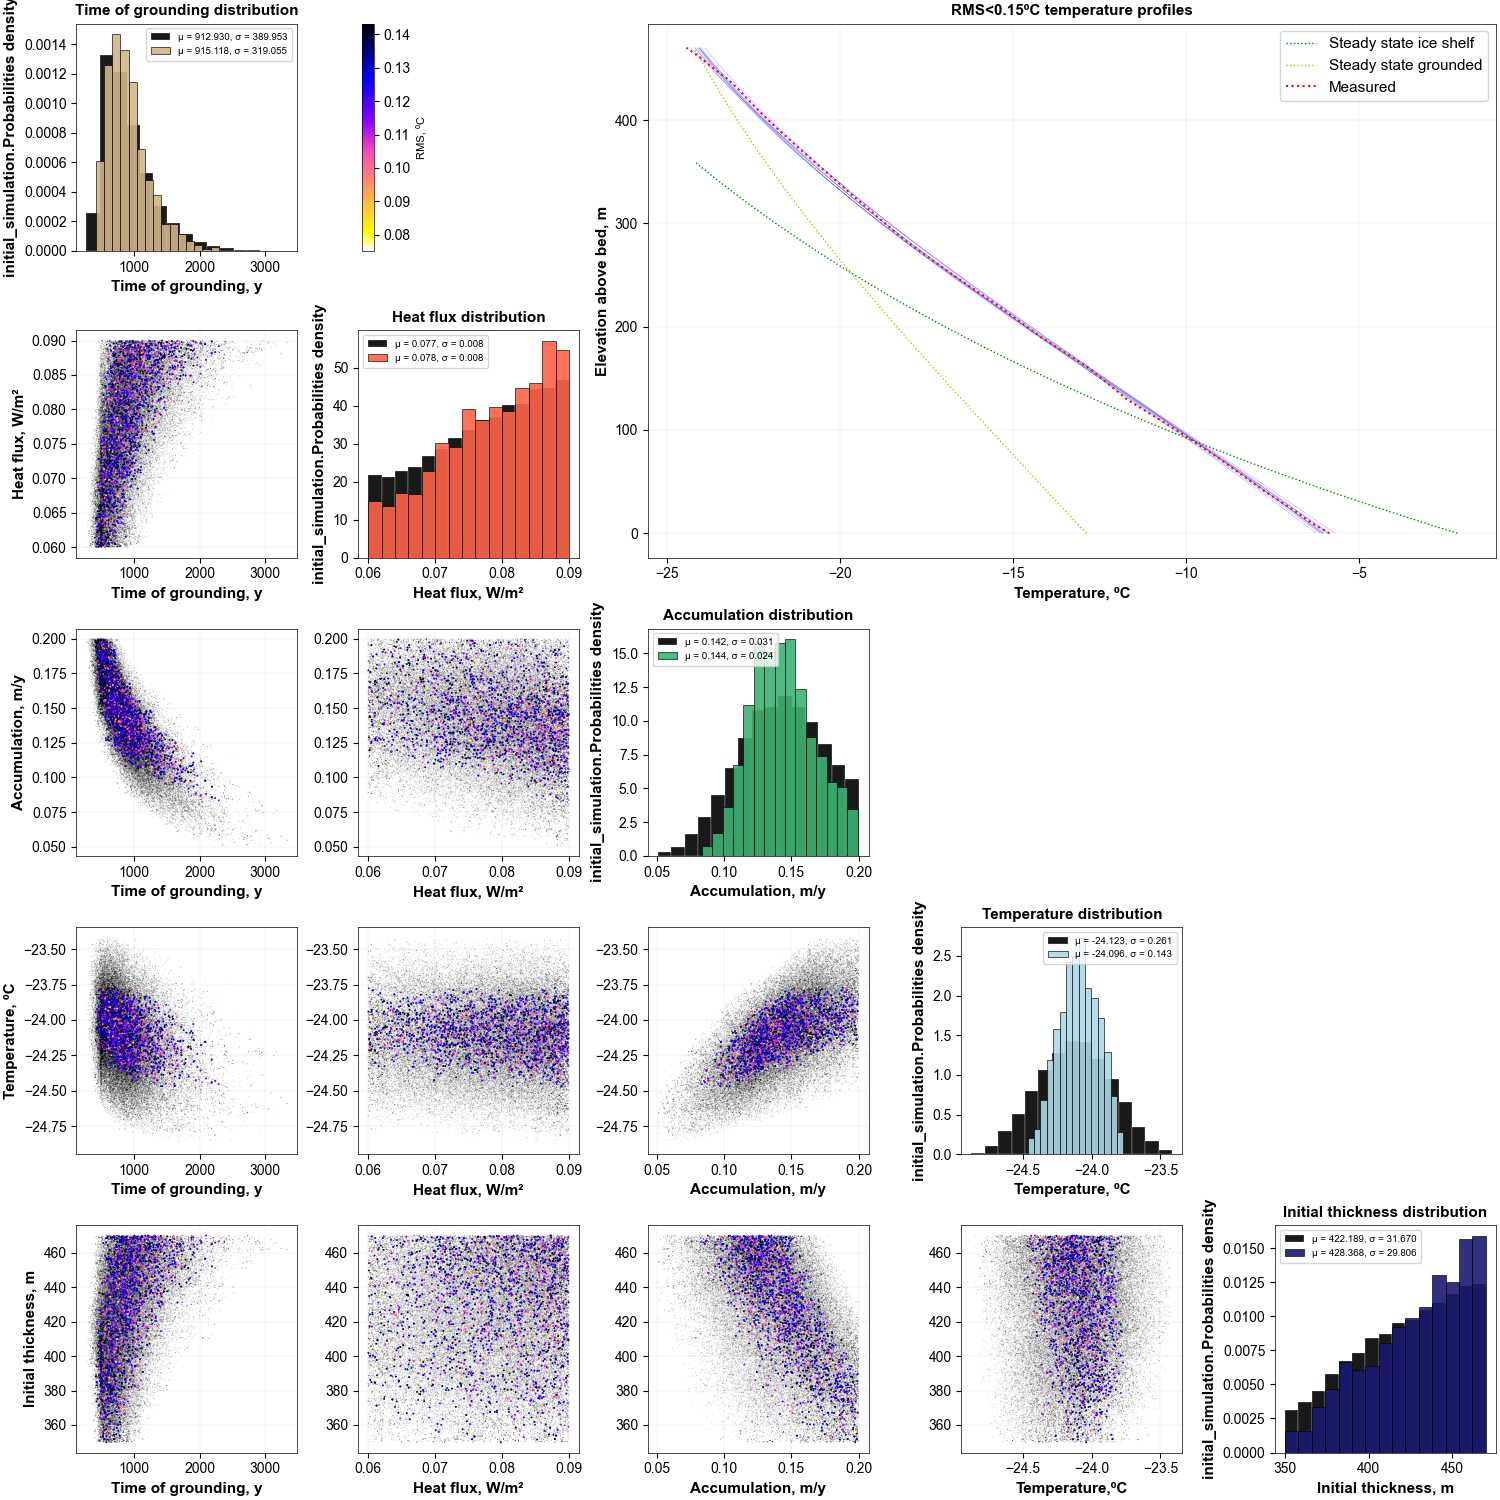

CPU times: total: 1.27 s
Wall time: 8.58 s


In [10]:
%%time

with Cell(dependencies="rms_likelihood"):
    lnprobmin = -2.5

    hs1 = initial_simulation.samples[(initial_simulation.probabilities > rms_likelihood.lnprobmax)][:,0][rms_likelihood.index]
    xs1 = initial_simulation.samples[(initial_simulation.probabilities > rms_likelihood.lnprobmax)][:,1][rms_likelihood.index]
    ys1 = initial_simulation.samples[(initial_simulation.probabilities > rms_likelihood.lnprobmax)][:,2][rms_likelihood.index]
    zs1 = initial_simulation.samples[(initial_simulation.probabilities > rms_likelihood.lnprobmax)][:,3][rms_likelihood.index]
    ts1 = initial_simulation.samples[(initial_simulation.probabilities > rms_likelihood.lnprobmax)][:,4][rms_likelihood.index]
    hs = initial_simulation.samples[(initial_simulation.probabilities > lnprobmin)][:,0]
    xs = initial_simulation.samples[(initial_simulation.probabilities > lnprobmin)][:,1]
    ys = initial_simulation.samples[(initial_simulation.probabilities > lnprobmin)][:,2]
    zs = initial_simulation.samples[(initial_simulation.probabilities > lnprobmin)][:,3]
    ts = initial_simulation.samples[(initial_simulation.probabilities > lnprobmin)][:,4]

    fig = plt.figure(figsize=(15, 15), constrained_layout=True)

    fig.suptitle('Results of MCMC inversion: random walk in multidimensional parameter space, {:0.0f} simulations.pdf'.format(len(initial_simulation.samples)), y=1.05)

    gs = GridSpec(5, 5, figure=fig)

    # Temperature profiles
    sub = fig.add_subplot(gs[0:2, 2:5])

    for theta in (initial_simulation.samples[(initial_simulation.probabilities>rms_likelihood.lnprobmax)])[np.random.randint(len(initial_simulation.samples[(initial_simulation.probabilities>rms_likelihood.lnprobmax)]), size=10)]:
        sub.plot(
            ModelMeasured(content.dt_years, *theta), 
            content.z[content.l-1:], 
            'b', 
            linewidth=0.25, 
            alpha=0.5,
        )

    sub.set_title('RMS<0.15ºC temperature profiles')
    sub.set_xlabel('Temperature, ºC')
    sub.set_ylabel('Elevation above bed, m')

    sub.plot(content.Tsteady_ice_shelf[content.l-1:], content.z[content.l-1:-11], 'g:', linewidth=1, label='Steady state ice shelf')
    sub.plot(content.Tsteady_grounded[content.l-1:], content.z[content.l-1:], 'y:', linewidth=1, label='Steady state grounded')
    sub.plot(content.Tmeasured, content.z[content.l-1:],'r:', linewidth=1.5,  label='Measured')

    sub.grid(linestyle='-', linewidth=0.1)

    sub.legend()

    # Common plots

    # ----------------------------------------------------------------------
    def AddScatterSubplot(
        grid_spec_loc,
        x_label,
        y_label,
        x1_values,
        y1_values,
        x2_values,
        y2_values,
    ):
        sub = fig.add_subplot(grid_spec_loc)

        for x_values, y_values, c, s, alpha in [
            (x1_values, y1_values, 'k', 0.5, 0.05),
            (x2_values, y2_values, rms_likelihood.rmslik, 2, 1),
        ]:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                
                scatter = sub.scatter(
                    x_values, 
                    y_values,
                    c=c,
                    s=s,
                    alpha=alpha,
                    edgecolors='none',
                    cmap='gnuplot2_r',
                )

        sub.grid(linestyle='-', linewidth=0.1)

        sub.set_xlabel(x_label)

        if y_label is not None:
            sub.set_ylabel(y_label)

        return scatter

    # ----------------------------------------------------------------------

    for args in [
        (gs[1, 0], 'Time of grounding, y', 'Heat flux, W/m²',      xs, ys, xs1, ys1),
        (gs[2, 0], 'Time of grounding, y', 'Accumulation, m/y',    xs, zs, xs1, zs1),
        (gs[2, 1], 'Heat flux, W/m²',       None,                  ys, zs, ys1, zs1),
        (gs[3, 0], 'Time of grounding, y', 'Temperature, ºC',      xs, ts, xs1, ts1),
        (gs[3, 1], 'Heat flux, W/m²',      None,                   ys, ts, ys1, ts1),
        (gs[3, 2], 'Accumulation, m/y',    None,                   zs, ts, zs1, ts1),
        (gs[4, 0], 'Time of grounding, y', 'Initial thickness, m', xs, hs, xs1, hs1),
        (gs[4, 1], 'Heat flux, W/m²',      None,                   ys, hs, ys1, hs1),
        (gs[4, 2], 'Accumulation, m/y',    None,                   zs, hs, zs1, hs1),
        (gs[4, 3], 'Temperature,ºC',       None,                   ts, hs, ts1, hs1),
    ]:
        scatter_content = AddScatterSubplot(*args)

    # ----------------------------------------------------------------------
    def AddHistSubplot(
        grid_spec_loc,
        title,
        x_label,
        secondary_color,
        primary_values,
        secondary_values,
    ):
        sub = fig.add_subplot(grid_spec_loc)

        for values, facecolor, edgecolor, linewidth in [
            (primary_values, "black", "white", 0.2),
            (secondary_values, secondary_color, "black", 0.5),
        ]:
            sub.hist(
                values,
                15, 
                density=True,
                facecolor=facecolor,
                edgecolor=edgecolor,
                alpha=0.9,
                linewidth=linewidth,
                label="\u03bc = {:0.3f}, \u03C3 = {:0.3f}".format(np.mean(values), np.std(values)),
            )

        sub.set_title(title)
        sub.set_xlabel(x_label)
        sub.set_ylabel("initial_simulation.Probabilities density")
        sub.legend(borderpad=0.5, prop={"size": 7})

    # ----------------------------------------------------------------------
    
    for args in [
        (gs[0, 0], 'Time of grounding distribution', 'Time of grounding, y', "tan",            xs, xs1),
        (gs[1, 1], 'Heat flux distribution',         'Heat flux, W/m²',      "tomato",         ys, ys1),
        (gs[2, 2], 'Accumulation distribution',      'Accumulation, m/y',    "mediumseagreen", zs, zs1),
        (gs[3, 3], 'Temperature distribution',       'Temperature, ºC',      "lightblue",      ts, ts1),
        (gs[4, 4], 'Initial thickness distribution', 'Initial thickness, m', "midnightblue",   hs, hs1),
    ]:
        AddHistSubplot(*args)

    # Colorbar
    sub = fig.add_subplot(gs[0, 1])
    
    fig.colorbar(
        scatter_content,
        ax=sub, 
        orientation="vertical", 
        pad=-1.0,
    ).set_label('RMS, ºC',weight = 'light',size = 8)
    
    sub.xaxis.set_visible(False)
    sub.yaxis.set_visible(False)
    sub.axis("off")
    
    plt.show()
